# Spatial and Temporal Analysis
Going to separate these two types of analysis, then potentially bring them back together.

In [125]:
import matplotlib.pyplot as plt
import geopandas as gpd
import shapely
import contextily as ctx
import folium
import pandas as pd
import datetime as dt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from sklearn.model_selection import train_test_split

**To recap the clusters:**

- Cluster 0 seems to be focused on Russian movements, troops, and vehicles.
- Cluster 1 seems to be focused on Russian and Ukrainian activity, agnostic of the type of activity. It also seems to be a catch-all cluster.
- Cluster 2 seems to be focused on Mariupol, one of the cities in Ukraine that was beseiged for months in 2022 before surrendering to the Russians. Spatial and temporal analysis should shed light on this cluster.
- Cluster 3 seems to be focused on destruction caused by shelling and artillery, but not necessarily one-sided or the other.
- Cluster 4 seems to be Ukrainian positions and actions its military takes, including Unmanned Aerial Vehicles (UAV) activity.
- Cluster 5 Seems to be specific activities and attacks related to Russian and Ukranian militaries in Donetsk Oblast, specifically the city of Bakhmut in that province.
- Cluster 6 largely focuses on what satelite imagery can glean, such as ships, positions, and noteworthy positions like bridges, rivers, and airports.

#### Spatial first - map the clusters, get counts of clusters within the country of Ukraine

This will help flesh out the spatial orientation of the clusters, if my assertion that there are more "global" clusters that exist.

Note: Spatial Autocorrelation is not indicative of anything in this type of study. There are no attributes to be pulled out (outside of incident data) that would offer reasoning behind logically that Ukraine-Russia War tweets are spatially correlated to where the action is taking place. That being said, there may be a spatial-temporal correlation that can be useful, so in future notebooks we'll set that one up.

In [2]:
geoconfirmed_clusters = pd.read_csv('../data/get_geoconfirmed_data_clusters.csv')

In [3]:
# First get the latitude and longitude columns in the dataframe into a point geometry column

geoconfirmed_clusters['geometry'] = geoconfirmed_clusters.apply(lambda row: shapely.Point(row['longitude'], row['latitude']), axis=1)

In [4]:
geoconfirmed_clusters = gpd.GeoDataFrame(geoconfirmed_clusters, geometry='geometry')

In [5]:
geoconfirmed_clusters.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 9047 entries, 0 to 9046
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   geoconfirmed_id  9047 non-null   object  
 1   icon             9047 non-null   object  
 2   id               9047 non-null   object  
 3   date             9047 non-null   object  
 4   latitude         9047 non-null   float64 
 5   longitude        9047 non-null   float64 
 6   place_desc       0 non-null      float64 
 7   title            9047 non-null   object  
 8   description      9047 non-null   object  
 9   source           9047 non-null   object  
 10  links            9047 non-null   object  
 11  filters          9047 non-null   object  
 12  list_text        9047 non-null   object  
 13  clusters         9047 non-null   int64   
 14  geometry         9047 non-null   geometry
dtypes: float64(3), geometry(1), int64(1), object(10)
memory usage: 1.0+ MB


In [6]:
geoconfirmed_clusters = geoconfirmed_clusters.set_crs("EPSG:4326", allow_override=True) # WGS 84 as popular plotting code

In [7]:
geoconfirmed_clusters.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [8]:
geoconfirmed_clusters.head(1)

,geoconfirmed_id,icon,id,date,latitude,longitude,place_desc,title,description,source,links,filters,list_text,clusters,geometry
0,c3453c33-2102-4490-1aea-08db064a2e33,_CIRCLES_E00000_RU_56_10.png,c3453c33-2102-4490-1aea-08db064a2e33,2022-02-24 00:00:00,47.943992,37.50156,NaN,04 1823 FEB 1527 - UAV -Tanks of the Russian S...,<br><br>Geo: <br>https://twitter.com/GeoConfi...,GEOCONFIRMED,['https://twitter.com/GeoConfirmed/status/1621...,[],- UAV -Tanks of the Russian Southern military...,1,POINT (37.50156 47.94399)


In [9]:
# # plot on a map, but specifically pull out the clusters so they are toggleable. Uncomment this if you want to see the map.

# m = folium.Map(location=[20,0], tiles="CartoDB Positron", zoom_start=2, prefer_canvas = True)

# # Create a FeatureGroup for each layer
# layer0 = folium.FeatureGroup(name=0, show = False)
# layer1 = folium.FeatureGroup(name=1, show = False) #this one causes it to load slowly, just fyi
# layer2 = folium.FeatureGroup(name=2, show = False)
# layer3 = folium.FeatureGroup(name=3, show = False)
# layer4 = folium.FeatureGroup(name=4, show = False)
# layer5 = folium.FeatureGroup(name=5, show = False)
# layer6 = folium.FeatureGroup(name=6, show = False)

# # Assuming you have a DataFrame called 'df' with a column named 'category'
# # Iterate over each row and add a marker to the corresponding layer based on the category
# for index, row in geoconfirmed_clusters.iterrows():
#     if row['clusters'] == 0:
#         folium.Marker([row['latitude'], row['longitude']], popup=row['list_text'], icon = folium.Icon(color='green')).add_to(layer0)
#     elif row['clusters'] == 1:
#         folium.Marker([row['latitude'], row['longitude']], popup=row['list_text'], icon = folium.Icon(color='cadetblue')).add_to(layer1)
#     elif row['clusters'] == 2:
#         folium.Marker([row['latitude'], row['longitude']], popup=row['list_text'], icon = folium.Icon(color='purple')).add_to(layer2)
#     elif row['clusters'] == 3:
#         folium.Marker([row['latitude'], row['longitude']], popup=row['list_text'], icon = folium.Icon(color='lightgray')).add_to(layer3)
#     elif row['clusters'] == 4:
#         folium.Marker([row['latitude'], row['longitude']], popup=row['list_text'], icon = folium.Icon(color='pink')).add_to(layer4)
#     elif row['clusters'] == 5:
#         folium.Marker([row['latitude'], row['longitude']], popup=row['list_text'], icon = folium.Icon(color='lightblue')).add_to(layer5)
#     elif row['clusters'] == 6:
#         folium.Marker([row['latitude'], row['longitude']], popup=row['list_text'], icon = folium.Icon(color='lightred')).add_to(layer6)

# # Add the layers to the map
# layer0.add_to(m)
# layer1.add_to(m)
# layer2.add_to(m)
# layer3.add_to(m)
# layer4.add_to(m)
# layer5.add_to(m)
# layer6.add_to(m)

# folium.LayerControl().add_to(m)

# m.save('../data/map.html')

# m

**Spatial Analysis**

- Cluster 0 seems to be focused on Russian movements, troops, and vehicles. It has more locations in Belarus over the other locations.
- Cluster 1 seems to be focused on Russian and Ukrainian activity, agnostic of the type of activity. It also seems to be a catch-all cluster. It is the most onerous to load, and it is likely full of outliers. Spatially, it is very global in nature, so I can call it Global Russia-Global Ukraine.
- Cluster 2 seems to be focused on Mariupol, one of the cities in Ukraine that was beseiged for months in 2022 before surrendering to the Russians. Spatially, this is confirmed, as almost the entirety of the points in this cluster are located in and around the city.
- Cluster 3 seems to be focused on destruction caused by shelling and artillery, but not necessarily one-sided or the other. This is presumably accurate spatially, as the points almost all are contained in Ukraine and in Russia near the border with Ukraine, where Ukraine has allegedly targeted locations with attacks.
- Cluster 4 seems to be Ukrainian positions and actions its military takes, including Unmanned Aerial Vehicles (UAV) activity. Spatially this seems accurate, as the vast majority of points are featured in that contact line that has emerged in eastern and southern Ukraine, almost no features outside of the country.
- Cluster 5 Seems to be specific activities and attacks related to Russian and Ukranian militaries in Donetsk Oblast, specifically the city of Bakhmut in that province. Spatially, there are some outliers in Kherson and elsewhere, but largely it seems like the points are featured in the Donetsk Oblast, around where Russia is pushing in the Donbas. 
- Cluster 6 largely focuses on what satelite imagery can glean, such as ships, positions, and noteworthy positions like bridges, rivers, and airports. This is confirmed spatially, as there are points in water, Belarus, deep in Russia, and in parts of Ukraine and Crimea not actively under ground assaults.

### Other Spatial EDA - Counts of Clusters in Ukraine (as proportion of total clusters)

In [10]:
# Read in Ukraine boundaries
Ukraine_bnd = gpd.read_file('https://github.com/wmgeolab/geoBoundaries/raw/905b0ba/releaseData/gbOpen/UKR/ADM0/geoBoundaries-UKR-ADM0_simplified.geojson')

In [11]:
#For each cluster count, generate how many are within this Ukraine boundary
cluster_0_ukr = gpd.sjoin(geoconfirmed_clusters[geoconfirmed_clusters['clusters'] == 0], Ukraine_bnd, how='inner', predicate='within')
cluster_1_ukr = gpd.sjoin(geoconfirmed_clusters[geoconfirmed_clusters['clusters'] == 1], Ukraine_bnd, how='inner', predicate='within')
cluster_2_ukr = gpd.sjoin(geoconfirmed_clusters[geoconfirmed_clusters['clusters'] == 2], Ukraine_bnd, how='inner', predicate='within')
cluster_3_ukr = gpd.sjoin(geoconfirmed_clusters[geoconfirmed_clusters['clusters'] == 3], Ukraine_bnd, how='inner', predicate='within')
cluster_4_ukr = gpd.sjoin(geoconfirmed_clusters[geoconfirmed_clusters['clusters'] == 4], Ukraine_bnd, how='inner', predicate='within')
cluster_5_ukr = gpd.sjoin(geoconfirmed_clusters[geoconfirmed_clusters['clusters'] == 5], Ukraine_bnd, how='inner', predicate='within')
cluster_6_ukr = gpd.sjoin(geoconfirmed_clusters[geoconfirmed_clusters['clusters'] == 6], Ukraine_bnd, how='inner', predicate='within')

In [12]:
# Generate a table of proportion of clusters within Ukraine's boundaries

ukr_list = []

for i in range(0, 7):
    new_row = len(gpd.sjoin(geoconfirmed_clusters[geoconfirmed_clusters['clusters'] == i], Ukraine_bnd, how='inner', predicate='within').index)/len(geoconfirmed_clusters[geoconfirmed_clusters['clusters'] == i].index)
    ukr_list.append(new_row)

ukr_table = pd.DataFrame({'Proportion in Ukraine' : ukr_list})

In [13]:
ukr_table

,Proportion in Ukraine
0,0.934932
1,0.860520
2,0.994580
3,0.959520
4,0.991430
5,0.996326
6,0.882239


Clusters 1, 3, and 6 are not as featured in Ukraine as the other clusters. This gels spatially and further cements that these clusters are organized differently than Clusters 2, 4, and 5.

#### Generate Centroids of Each of the Clusters

This will help showcase the "center of mass" for each of the clusters - easier to visually see than an agglomeration of points.

In [14]:
ukr_list = []

for i in range(0, 7):
    geoconfirmed_clusters['geometry'] = geoconfirmed_clusters['geometry'].to_crs('EPSG:20007') # https://spatialreference.org/ref/epsg/20007/
    new_row = geoconfirmed_clusters[geoconfirmed_clusters['clusters'] == i].unary_union.centroid
    print(new_row)
    ukr_list.append(new_row)

ukr_centroids = pd.DataFrame({'geometry' : ukr_list})
ukr_centroids = gpd.GeoDataFrame(ukr_centroids, geometry='geometry')
ukr_centroids['geometry'] = ukr_centroids['geometry'].set_crs('EPSG:20007')
ukr_centroids['geometry'] = ukr_centroids['geometry'].to_crs(crs = 'EPSG:4326')
ukr_centroids['clust'] = [i for i in range(0, 7)]

POINT (7377939.997300926 5378596.433290375)
POINT (7287827.366879141 5463815.524095484)
POINT (7391453.933496838 5225284.340165216)
POINT (7268997.158707035 5425087.064865282)
POINT (7335375.079672592 5372480.218529574)
POINT (7389716.719797775 5363020.794167362)
POINT (7164941.747286531 5336590.657097955)


In [15]:
ukr_centroids

,geometry,clust
0,POINT (37.34584 48.52834),0
1,POINT (36.08282 49.26969),1
2,POINT (37.56722 47.15240),2
3,POINT (35.84658 48.91516),3
4,POINT (36.77235 48.46366),4
5,POINT (37.50934 48.39050),5
6,POINT (34.50164 48.07434),6


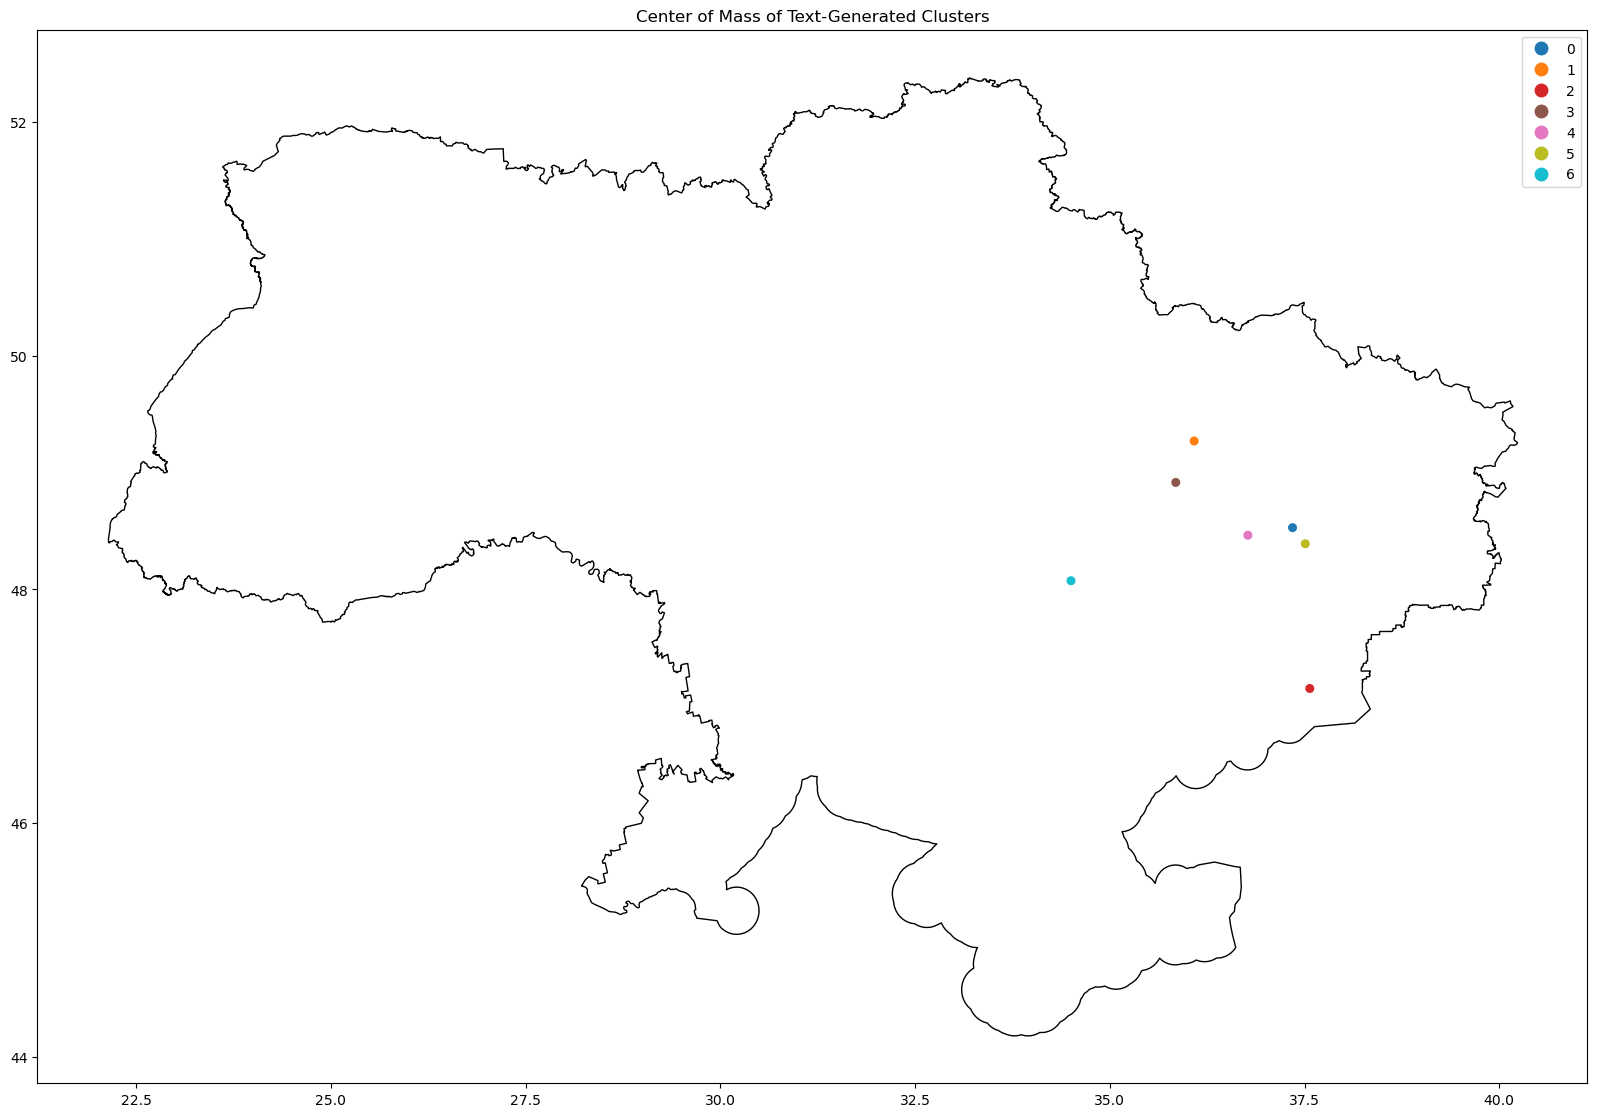

In [16]:
#map this
base = Ukraine_bnd.plot(color='white', edgecolor='black', figsize = (20, 20))

ukr_centroids.plot(column = 'clust', ax=base, marker='o', markersize=30, legend = True, categorical = True)
plt.title('Center of Mass of Text-Generated Clusters');

Based on the "Center of Mass" of events, we can see that Cluster 2 (Mariupol Cluster) is focused around that city, and Clusters 0 and 5 are focused around the area of Bakhmut in the Donetsk Oblast. Cluster 6, the Satellite Cluster, is focused towards the center of Ukraine, signifying a more regional or global cluster. Clusters 3 and 4 have a more westward focus, as these clusters seem to be focused on activities that take place on the Ukrainian side of the front (attacks on Ukraine, actions Ukraine takes against Russia). 

The one thing this helped me understand more is Cluster 0, which at first I believed was focused on troop movements largely outside of Ukraine. It turns out that the movements outside of Ukraine are largely outliers, and this cluster is still focused on troop movements around the Bakhmut area.

## Temporal Analysis

Since the data has already been segmented into clusters, my EDA will consist of modeling the incidents within each of the clusters for time series analysis, including some forecasting capability with a linear regression model.

Note that ARIMA or SARIMA/SARIMAX cannot be used because there is no variable to compare it to. It is just the frequency over time, which works for linear regression but not for ARIMA.

In [17]:
# Inside the data source is a Date field, set that to be a pandas date

geoconfirmed_clusters['cal_date'] = pd.to_datetime(geoconfirmed_clusters['date'], format = "%Y/%m/%d")
geoconfirmed_clusters['cal_date'] = geoconfirmed_clusters['cal_date'].dt.date

In [18]:
geoconfirmed_clusters.head(1)

,geoconfirmed_id,icon,id,date,latitude,longitude,place_desc,title,description,source,links,filters,list_text,clusters,geometry,cal_date
0,c3453c33-2102-4490-1aea-08db064a2e33,_CIRCLES_E00000_RU_56_10.png,c3453c33-2102-4490-1aea-08db064a2e33,2022-02-24 00:00:00,47.943992,37.50156,NaN,04 1823 FEB 1527 - UAV -Tanks of the Russian S...,<br><br>Geo: <br>https://twitter.com/GeoConfi...,GEOCONFIRMED,['https://twitter.com/GeoConfirmed/status/1621...,[],- UAV -Tanks of the Russian Southern military...,1,POINT (7388173.007 5313385.515),2022-02-24


In [19]:
#create a new dataframe and change the index to the new date column
time_series_df = geoconfirmed_clusters
time_series_df.set_index(time_series_df['cal_date'], drop = True, inplace = True)

In [20]:
time_series_df.head()

,geoconfirmed_id,icon,id,date,latitude,longitude,place_desc,title,description,source,links,filters,list_text,clusters,geometry,cal_date
cal_date,,,,,,,,,,,,,,,,
2022-02-24,c3453c33-2102-4490-1aea-08db064a2e33,_CIRCLES_E00000_RU_56_10.png,c3453c33-2102-4490-1aea-08db064a2e33,2022-02-24 00:00:00,47.943992,37.501560,NaN,04 1823 FEB 1527 - UAV -Tanks of the Russian S...,<br><br>Geo: <br>https://twitter.com/GeoConfi...,GEOCONFIRMED,['https://twitter.com/GeoConfirmed/status/1621...,[],- UAV -Tanks of the Russian Southern military...,1,POINT (7388173.007 5313385.515),2022-02-24
2022-02-24,46ee6b93-3123-4dd5-1aeb-08db064a2e33,_CIRCLES_E00000_RU_56_41.png,46ee6b93-3123-4dd5-1aeb-08db064a2e33,2022-02-24 00:00:00,47.942502,37.510458,NaN,04 1823 FEB 1527 - UAV -Tanks of the Russian S...,<br><br>Geo: <br>https://twitter.com/GeoConfi...,GEOCONFIRMED,['https://twitter.com/GeoConfirmed/status/1621...,[],- UAV -Tanks of the Russian Southern military...,1,POINT (7388834.521 5313206.976),2022-02-24
2022-01-04,02845209-9d18-4e24-953f-08daee4f2faa,_CIRCLES_0051CA_UA_56_10.png,02845209-9d18-4e24-953f-08daee4f2faa,2022-01-04 09:54:00,48.487650,37.921600,NaN,04 0954 JAN 2022 - UAV - Russian infantry was ...,<br><br>Geo: <br>https://twitter.com/GeoConfi...,GEOCONFIRMED,['https://twitter.com/GeoConfirmed/status/1610...,[],- UAV - Russian infantry was shelled by Ukrai...,4,POINT (7420400.298 5373312.158),2022-01-04
2022-01-15,0b86fdc5-710f-48ea-ff9a-08db377076ae,_CIRCLES_E00000_RU_56_161.png,0b86fdc5-710f-48ea-ff9a-08db377076ae,2022-01-15 17:00:00,52.052420,29.153457,NaN,15 1700 JAN 2022,Russian Train with logistical vehicles in Mazy...,GEOCONFIRMED,['https://www.tiktok.com/@stas_283/video/70570...,[],Russian Train with logistical vehicles in Maz...,1,POINT (6825485.720 5815187.403),2022-01-15
2022-01-21,e8be8693-6004-4229-e97f-08db2b2273bb,_CIRCLES_E00000_RU_56_161.png,e8be8693-6004-4229-e97f-08db2b2273bb,2022-01-21 09:02:00,52.349306,30.393528,NaN,21 0902 JAN 2022,Russian train with military equipment was spot...,GEOCONFIRMED,['https://twitter.com/Hajun_BY/status/14844361...,[],Russian train with military equipment was spo...,1,POINT (6914215.652 5837265.818),2022-01-21


In [21]:
#Since clusters are still in there, now I can start figuring out some interesting things about time
time_series_df.sort_index(axis = 0, inplace = True)

#generate counts of activities per day for each cluster
activity_counts_df = time_series_df.groupby([time_series_df['cal_date'], 'clusters']).size().unstack(fill_value=0)

activity_counts_df = activity_counts_df.reset_index()

activity_counts_df

clusters,cal_date,0,1,2,3,4,5,6
0,2022-01-04,0,0,0,0,1,0,0
1,2022-01-15,0,1,0,0,0,0,0
2,2022-01-21,0,2,0,0,0,0,0
3,2022-01-22,0,2,0,0,0,0,0
4,2022-01-24,0,2,0,0,0,0,0
...,...,...,...,...,...,...,...,...
418,2023-04-17,0,5,0,1,0,16,1
419,2023-04-18,1,7,0,3,0,17,0
420,2023-04-19,3,4,0,1,0,18,0
421,2023-04-20,0,3,0,1,0,15,0


In [22]:
activity_counts_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 423 entries, 0 to 422
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   cal_date  423 non-null    object
 1   0         423 non-null    int64 
 2   1         423 non-null    int64 
 3   2         423 non-null    int64 
 4   3         423 non-null    int64 
 5   4         423 non-null    int64 
 6   5         423 non-null    int64 
 7   6         423 non-null    int64 
dtypes: int64(7), object(1)
memory usage: 26.6+ KB


In [23]:
#Drop the row that is in December
activity_counts_df = activity_counts_df[activity_counts_df['cal_date'] <= dt.datetime.now().date()].copy()

In [24]:
activity_counts_df['cal_date'] = pd.to_datetime(activity_counts_df['cal_date'])
activity_counts_df.set_index(activity_counts_df['cal_date'], drop = True, inplace = True)
activity_counts_df.sort_index(axis = 0, inplace = True)

In [25]:
activity_counts_df.drop(columns = 'cal_date', inplace = True)

In [26]:
#rename columns for ease of plotting
activity_counts_df.rename(columns = {0: 'Cluster_0', 1: 'Cluster_1', 2: 'Cluster_2',
                                    3: 'Cluster_3', 4: 'Cluster_4', 5: 'Cluster_5', 6: 'Cluster_6'}, inplace = True)

In [27]:
activity_counts_df.columns

Index(['Cluster_0', 'Cluster_1', 'Cluster_2', 'Cluster_3', 'Cluster_4',
       'Cluster_5', 'Cluster_6'],
      dtype='object', name='clusters')

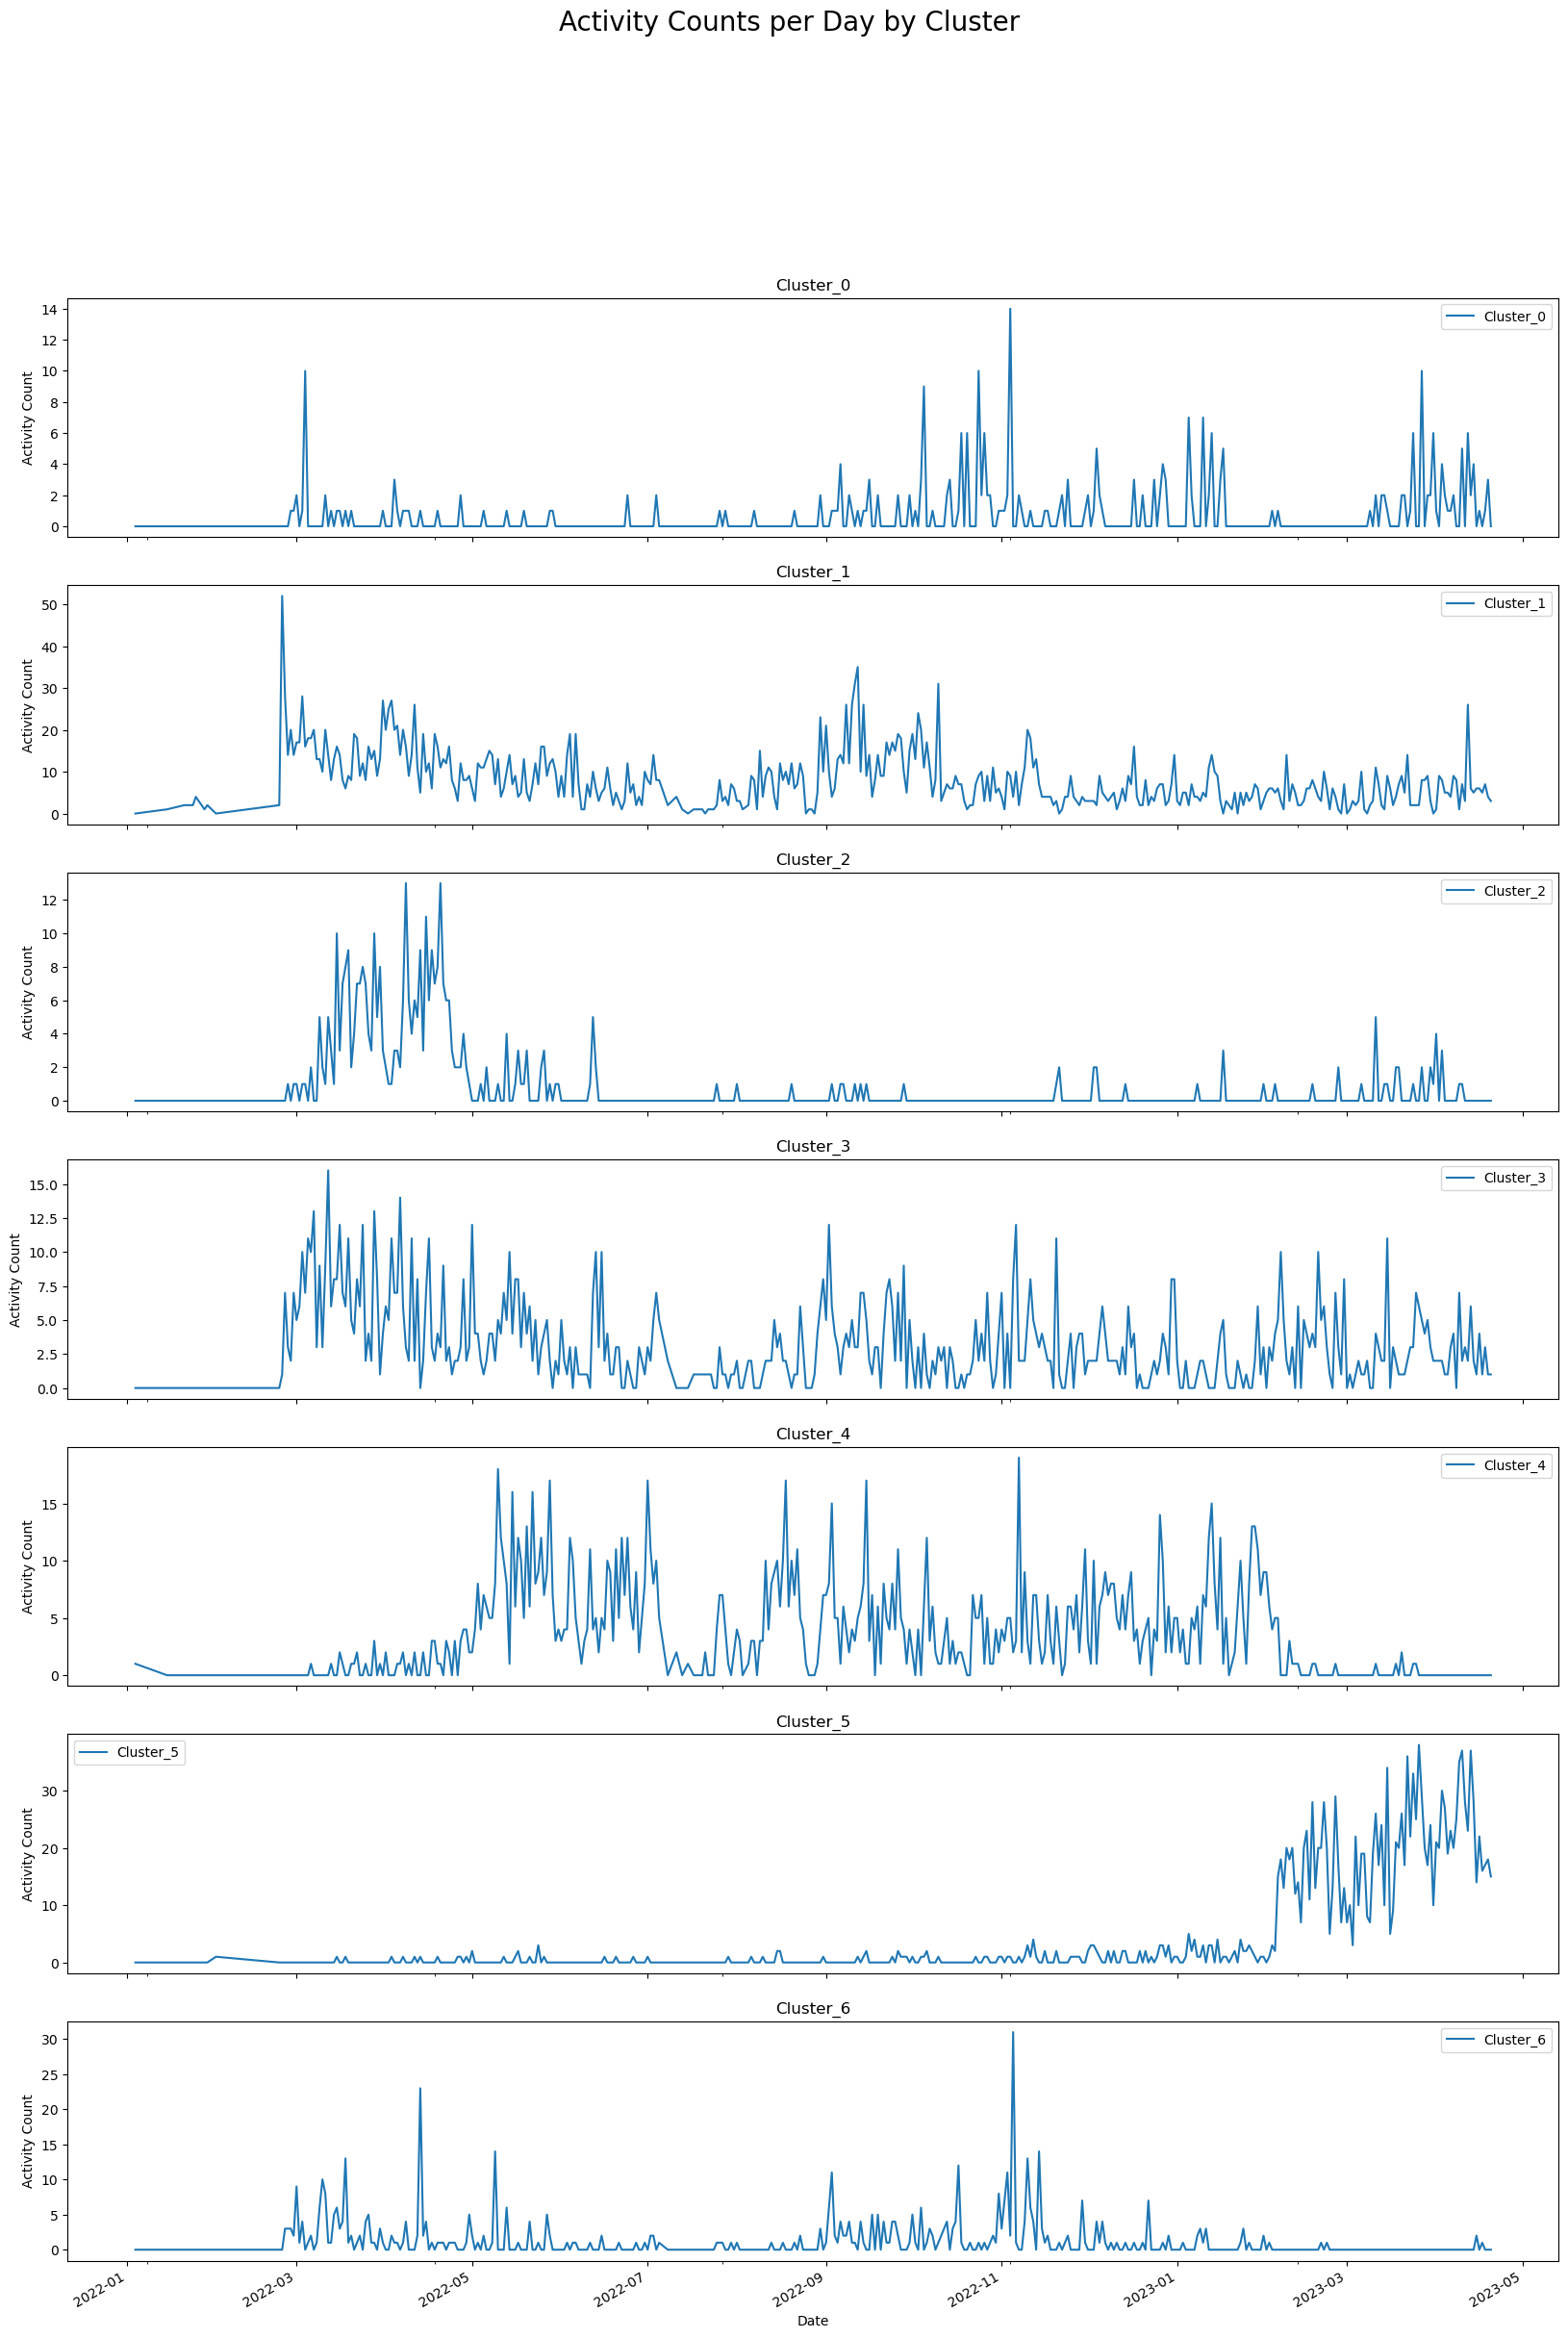

In [28]:
#sub plot of cluster activity over time
columns = activity_counts_df.columns[0:7]

fig, axs = plt.subplots(7, 1, sharex = True, figsize = (20, 30))
fig.suptitle('Activity Counts per Day by Cluster', fontsize = 20)

for i, col in enumerate(columns):
    ax = axs[i]
    activity_counts_df.plot(y=col, kind='line', ax=ax)
    ax.set_xlabel('Date')
    ax.set_ylabel('Activity Count')
    ax.set_title(col)
    ax.get_xticklabels()


There does appear to be a cyclical nature of each of the clusters:
- Cluster 0 had an early February and March 2022 spike, as Russia was attempting to push really deep into Ukraine. This was when there were troops moving around all over the country and in neighboring Belarus and Russia. Then, as Russia was repelled and focused efforts in the Donbas, they were not moving troops around as much. Then, in late August-early September, Russia announced a troop mobilization effort, and moved soldiers into the parts of captured Ukraine it controls. We see a recent spike because Russia has been moving troops into the Donbas as part of a Spring offensive.
- Cluster 2 is very indicative of the Mariupol seige. There was a huge spike in the early part of the war as Russia beseiged and bombed the city. Then, when the Ukrainian soldiers in the city surrendered, a lag in activity. Recently there were some activity as Russian President Vladimir Putin visited the captured city in March.
- Cluster 3 has been largely constant, as this war has resulted in immense amounts of destruction. There was a little bit of a lull in the Summer 2022 timeframe, as seemingly both sides had been limiting their artillery strikes as the battle lines stagnated. Then in the Fall of 2022, Ukraine had a counteroffensive to take back the city of Kherson among other territorial reclaimations, and Russia began wholesale targeting civilian electrical and power infrastructure. Cluster 3 seems attuned to the war-related events (as it is focused on destruction-based social media posts), so if the battle landscape changes, this will likely move with it.
- Cluster 4 is associated with Ukrainian activities, and spikes are seen during Ukrainian offsensives (likely when people are focusing on Ukrainian activities more so than Russians). This is because of spikes in May 2022, when Russia retreated out of parts of Ukraine, August-September 2022, when Ukraine launched a counter offensive. It's been stagnant as Ukraine has focused on defending Bakhmut and not doing much else. If Ukraine launched a counter offensive, we would hopefully see this cluster's activity spike to prove the theory.
- Cluster 5 is the trickiest to understand. Very very little activity until November 2022 timeframe, and most recently has spiked in activity. This is probably because of Russia's focus on taking Bakhmut. Presumably, if one side or the other were to take this city and move elsewhere, we would see a drop in activity in this Cluster.
- Cluster 6 has two distinct spikes in activity, one during the initial phases of the war, and one during the Fall of 2022. It has been largely static since. Believe the spikes in activity were associated with satellite imagery gleaning information about human rights atrocities in cities that Russia had evacuated, notably Bucha in April 2022, and when Russia began targeting energy and electrical infrastructure beginning in September 2022. If satellite imagery becomes useful again, in identifying human rights abuses among other war-related issues, we should see a spike in activity.

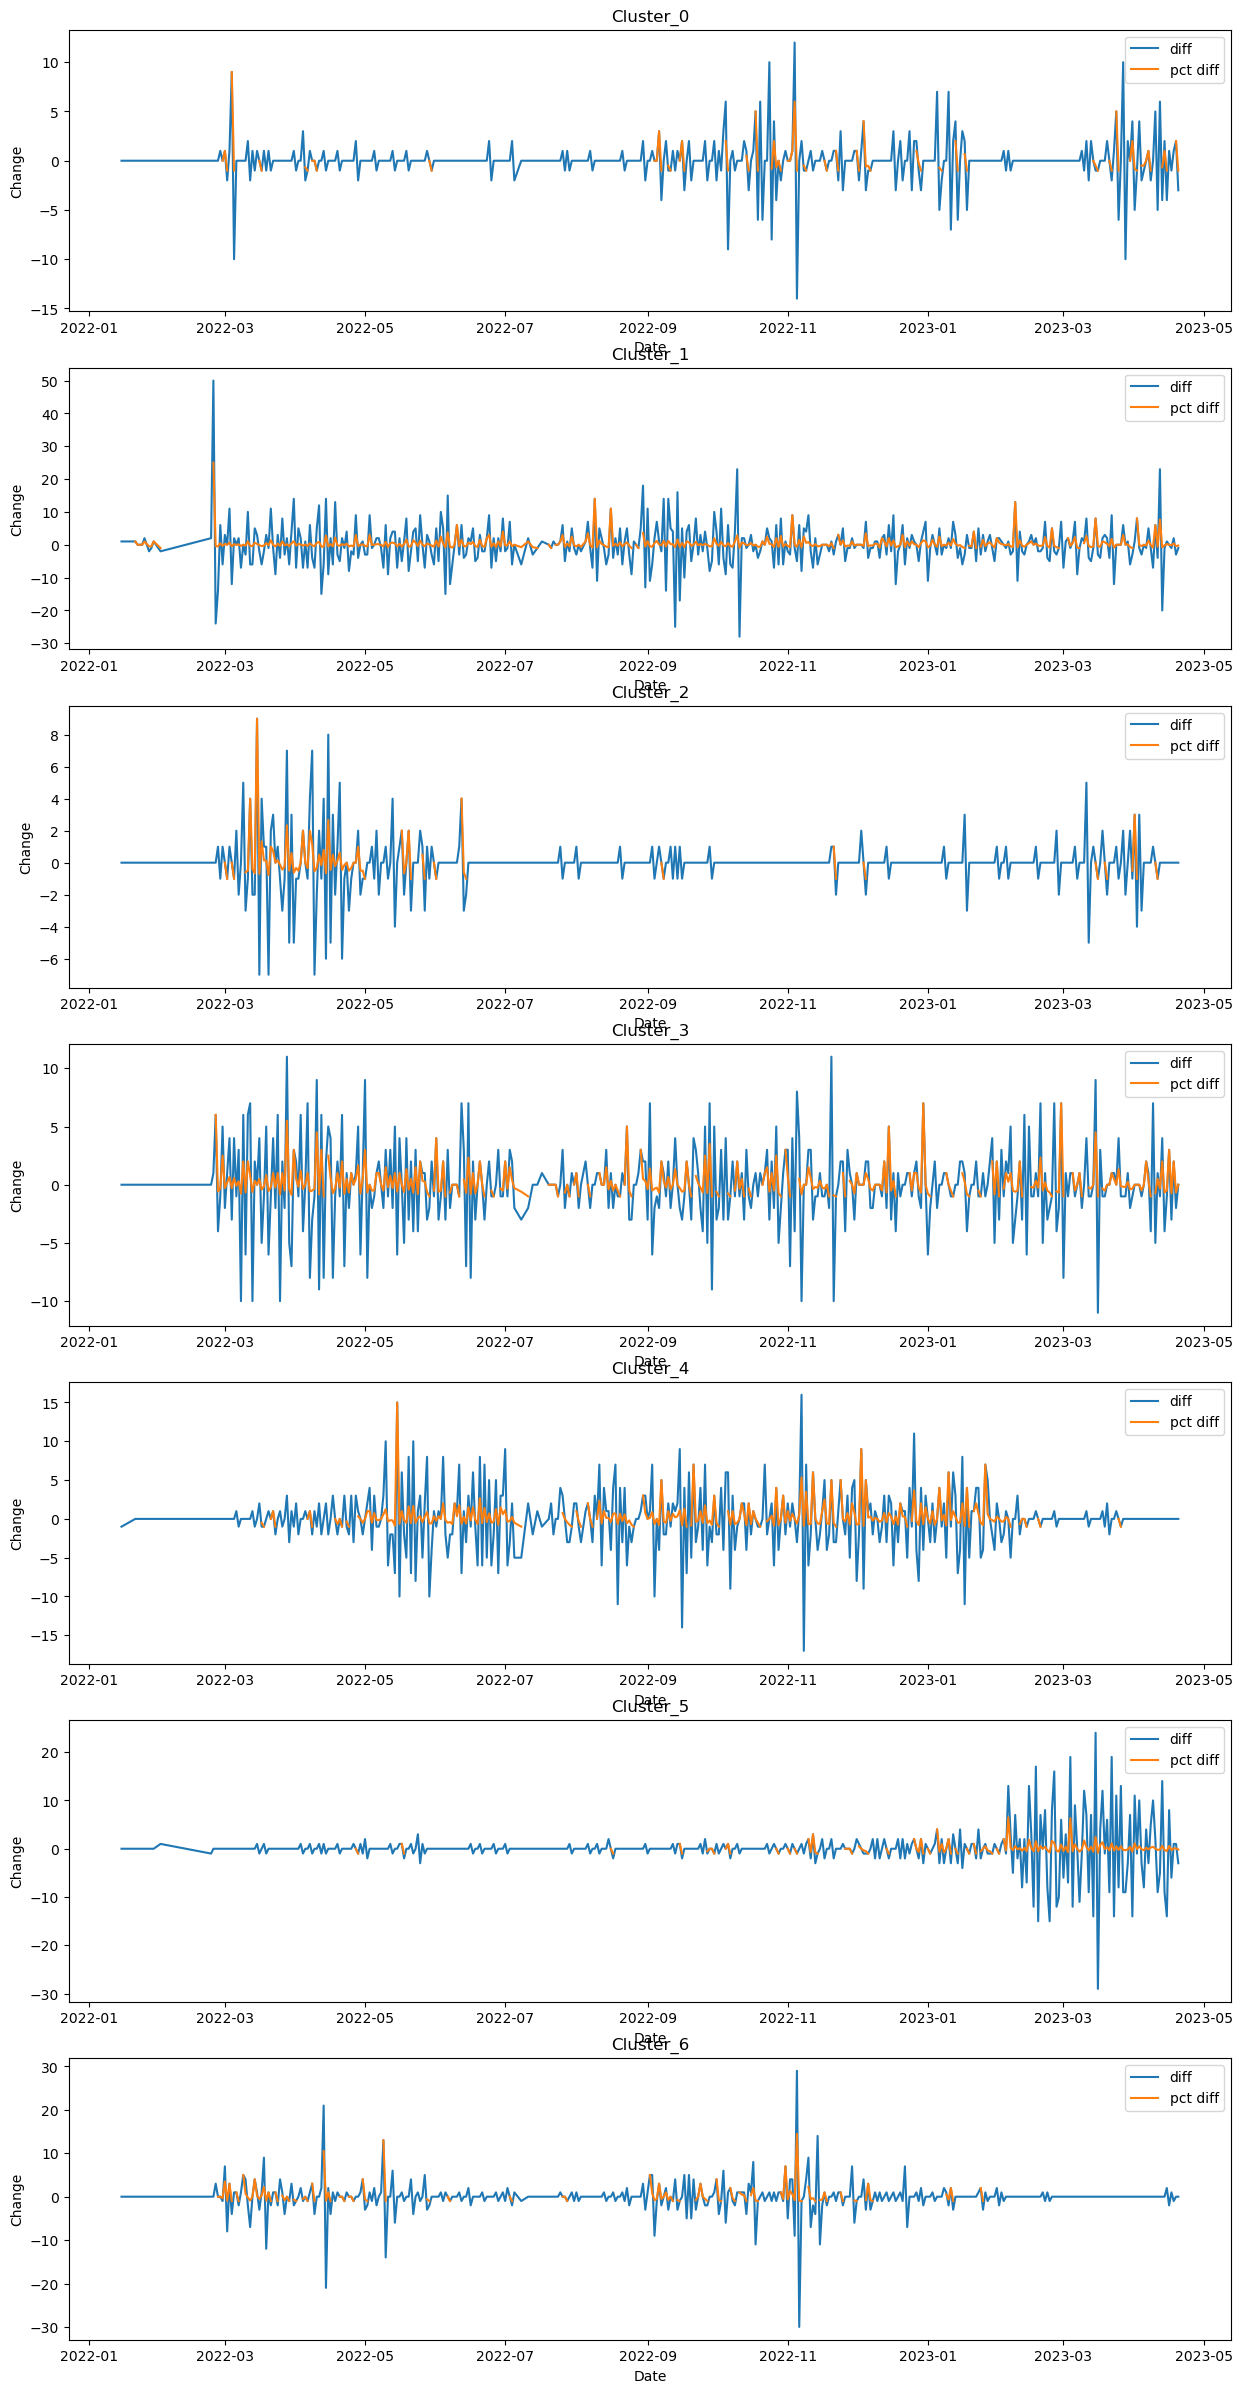

In [54]:
# Let's check for the all-important stationarity of the time series data, for plotting and modeling purposes
fig, axs = plt.subplots(nrows=7, figsize=(15,30))

for i, col in enumerate(columns):
    ax = axs[i]
    axs[i].plot(activity_counts_df[col].diff())
    axs[i].plot(activity_counts_df[col].pct_change())
    ax.set_xlabel('Date')
    ax.set_ylabel('Change')
    ax.set_title(col)
    ax.legend(['diff', 'pct diff'])

Difference can be used because it stays largely stationary. Next is to check the autocorrelation for each of the time series, using an autocorrelation plot and a partial autocorrelation plot.

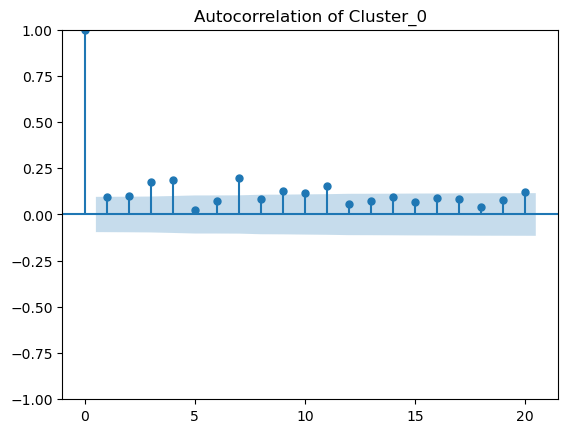

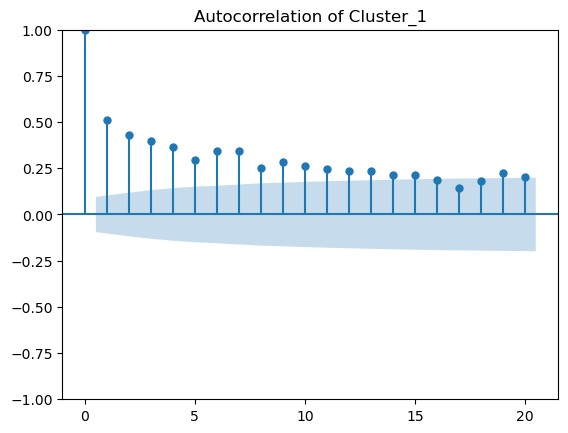

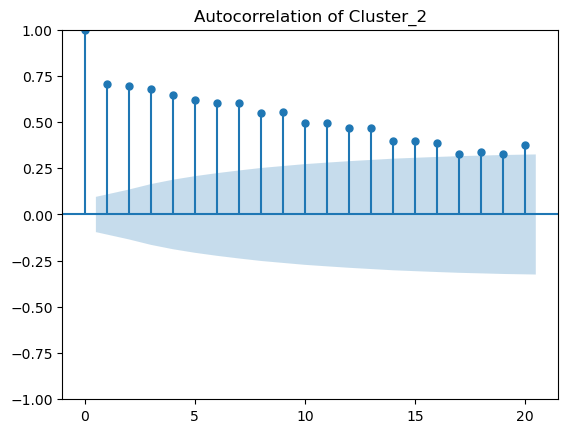

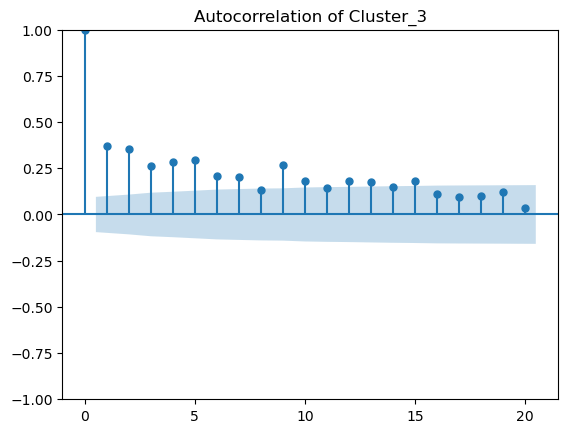

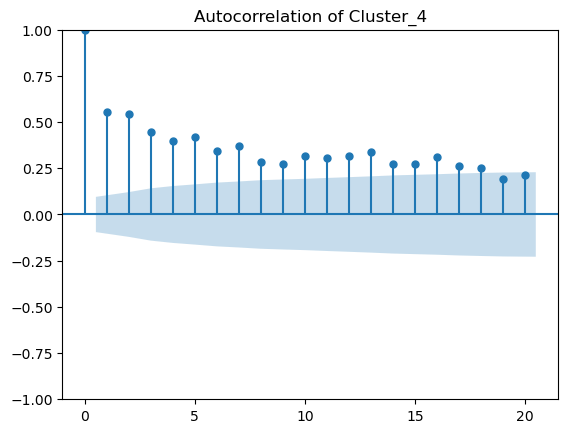

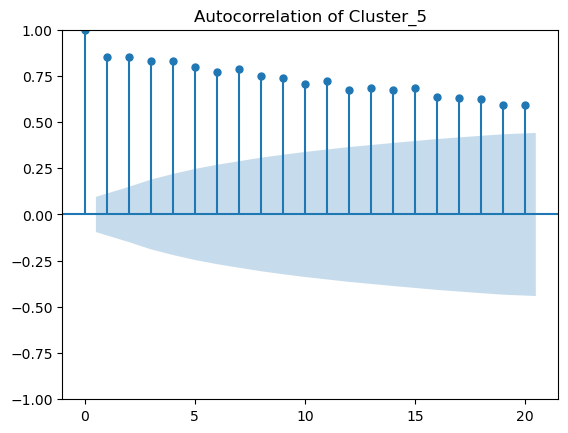

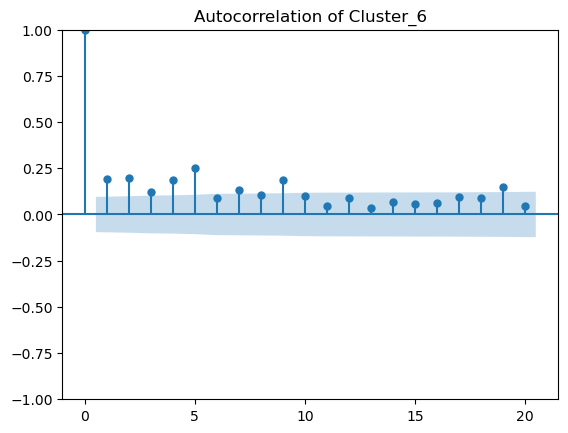

In [58]:
#Full Autocorrelation of Time Series
for i in activity_counts_df:
    plot_acf(activity_counts_df[i], lags = 20, title = 'Autocorrelation of ' + i );

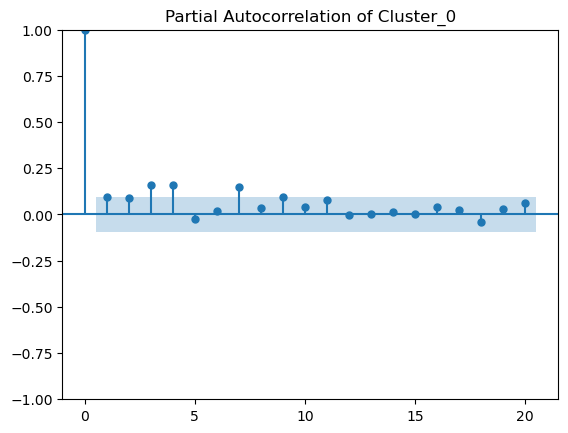

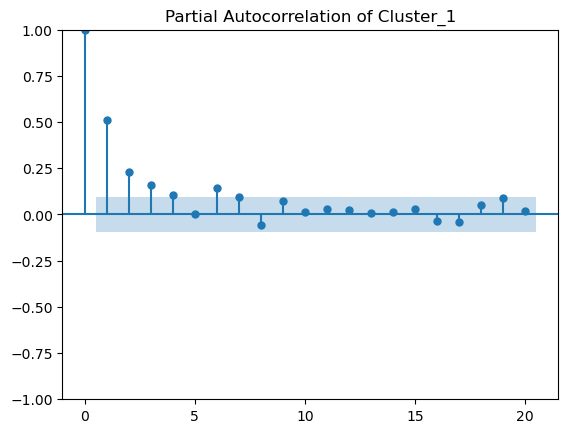

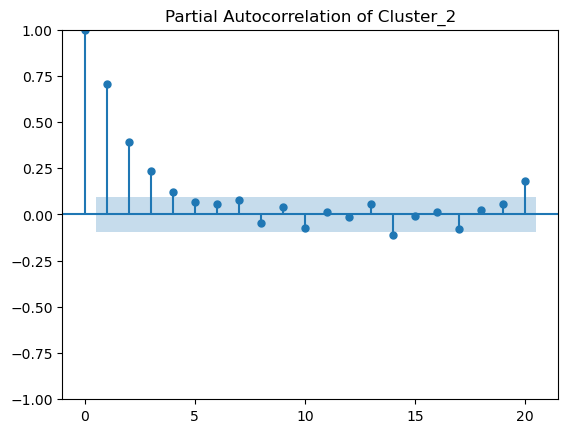

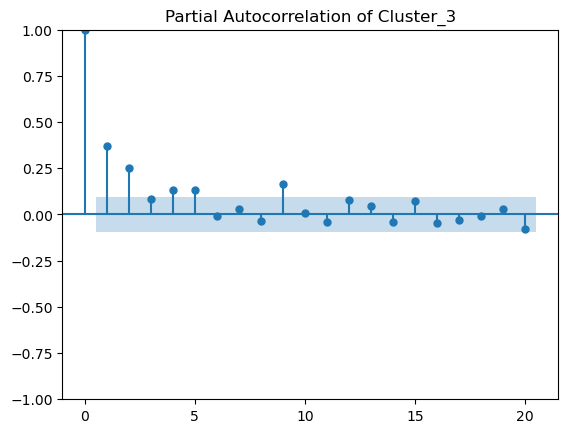

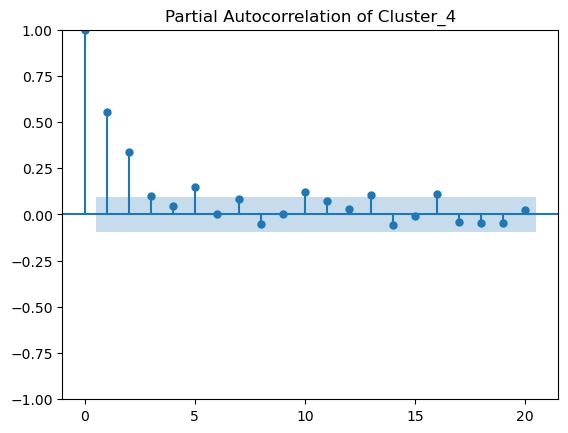

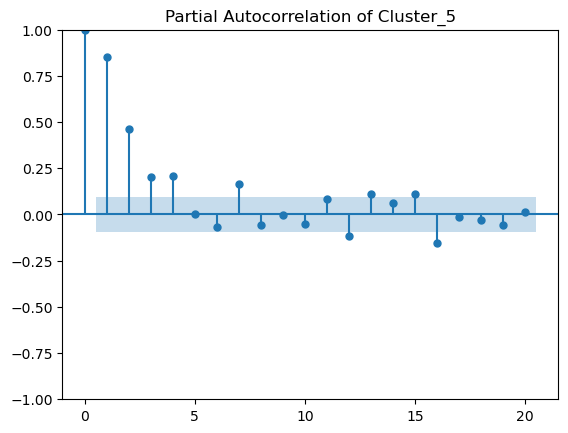

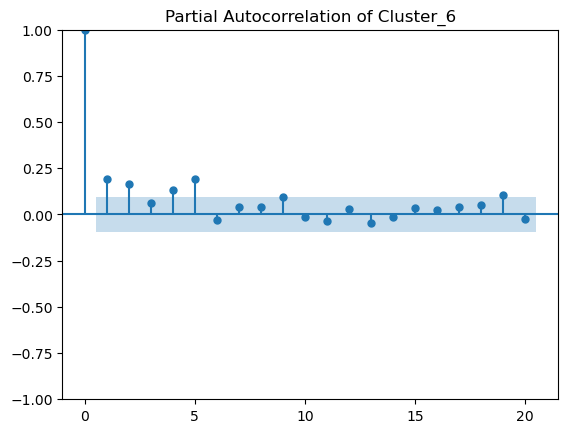

In [60]:
#Partial Autocorrelation of Time Series
for i in activity_counts_df:
    plot_pacf(activity_counts_df[i], lags = 20, title = 'Partial Autocorrelation of ' + i, method='ywm' );

In reading these plots, there exists trends in the frequency of posts at the beginning and middle of the data collection, but with the exception of Cluster 5 has begun to converge into a steady-state trendless set of posts. Cluster 5 is different in that the trend is currently bucked due to more frequent data more recently. In terms of seasonality (Partial Autocorrelation), there does not really exist a demonstrable pattern of seasonality in the data.

The summary of Cluster_0 is:
                            OLS Regression Results                            
Dep. Variable:              Cluster_0   R-squared:                       0.100
Model:                            OLS   Adj. R-squared:                  0.088
Method:                 Least Squares   F-statistic:                     8.343
Date:                Mon, 08 May 2023   Prob (F-statistic):           2.14e-06
Time:                        17:15:03   Log-Likelihood:                -562.26
No. Observations:                 307   AIC:                             1135.
Df Residuals:                     302   BIC:                             1153.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.138

The summary of Cluster_5 is:
                            OLS Regression Results                            
Dep. Variable:              Cluster_5   R-squared:                       0.200
Model:                            OLS   Adj. R-squared:                  0.189
Method:                 Least Squares   F-statistic:                     18.89
Date:                Mon, 08 May 2023   Prob (F-statistic):           7.13e-14
Time:                        17:15:04   Log-Likelihood:                -367.80
No. Observations:                 307   AIC:                             745.6
Df Residuals:                     302   BIC:                             764.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.181

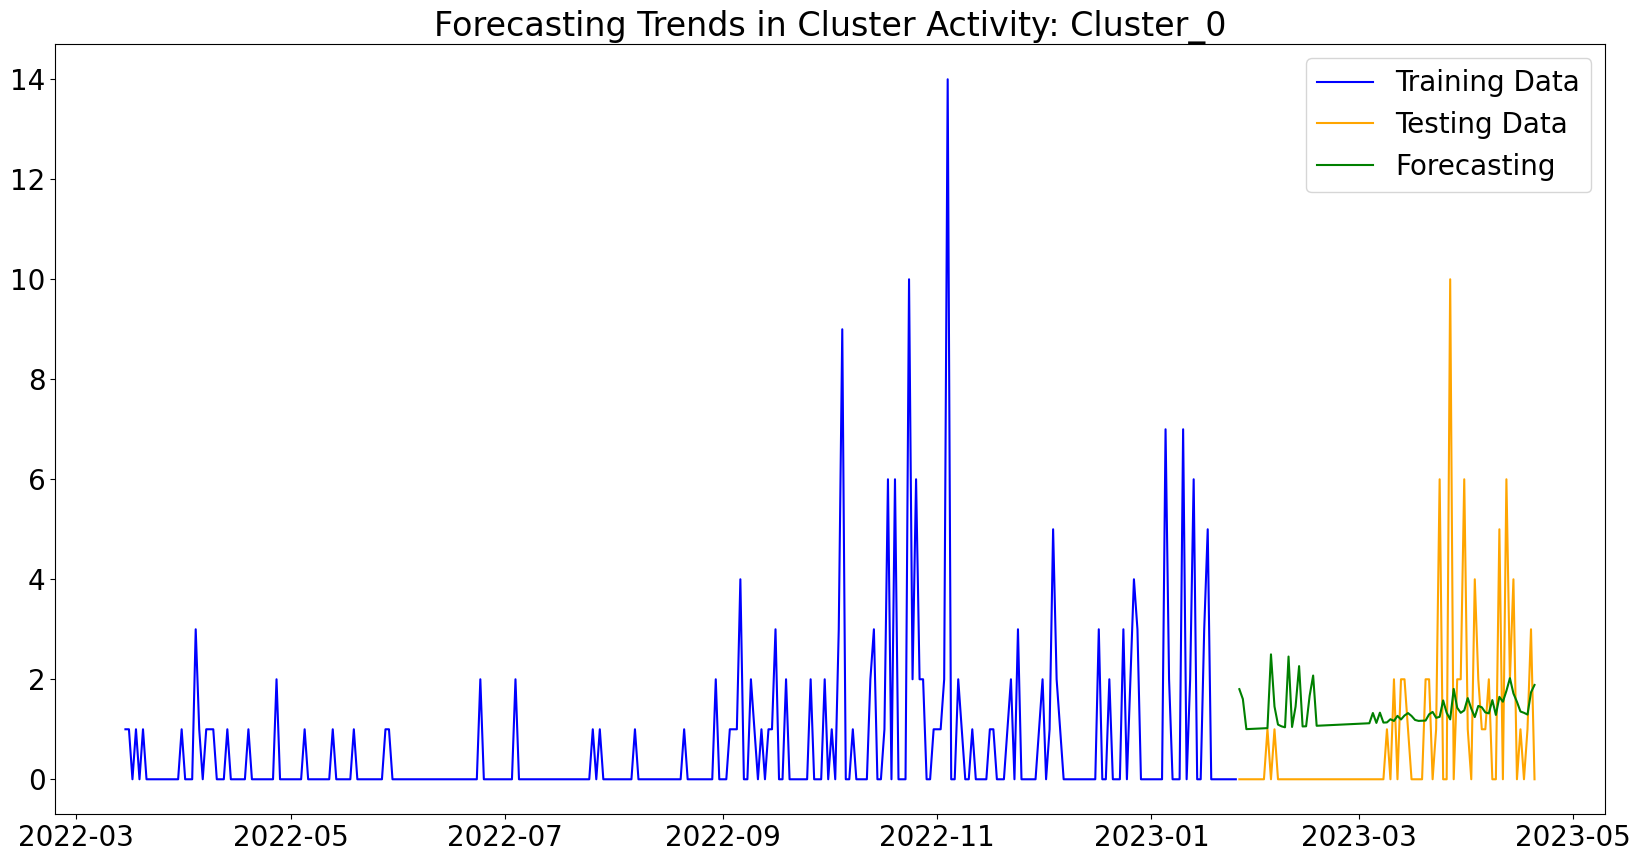

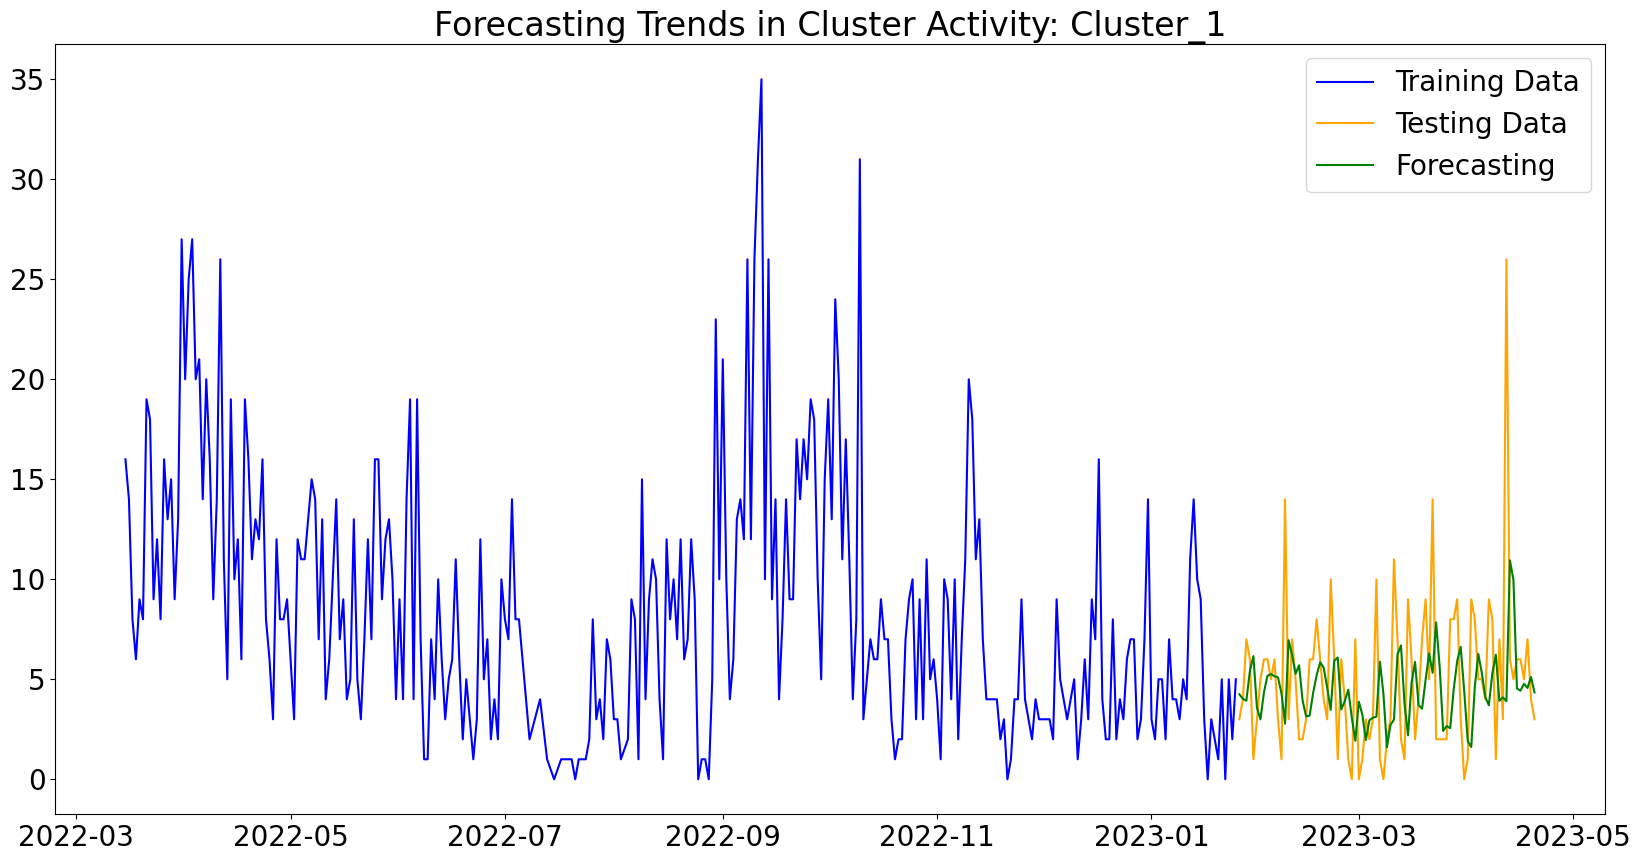

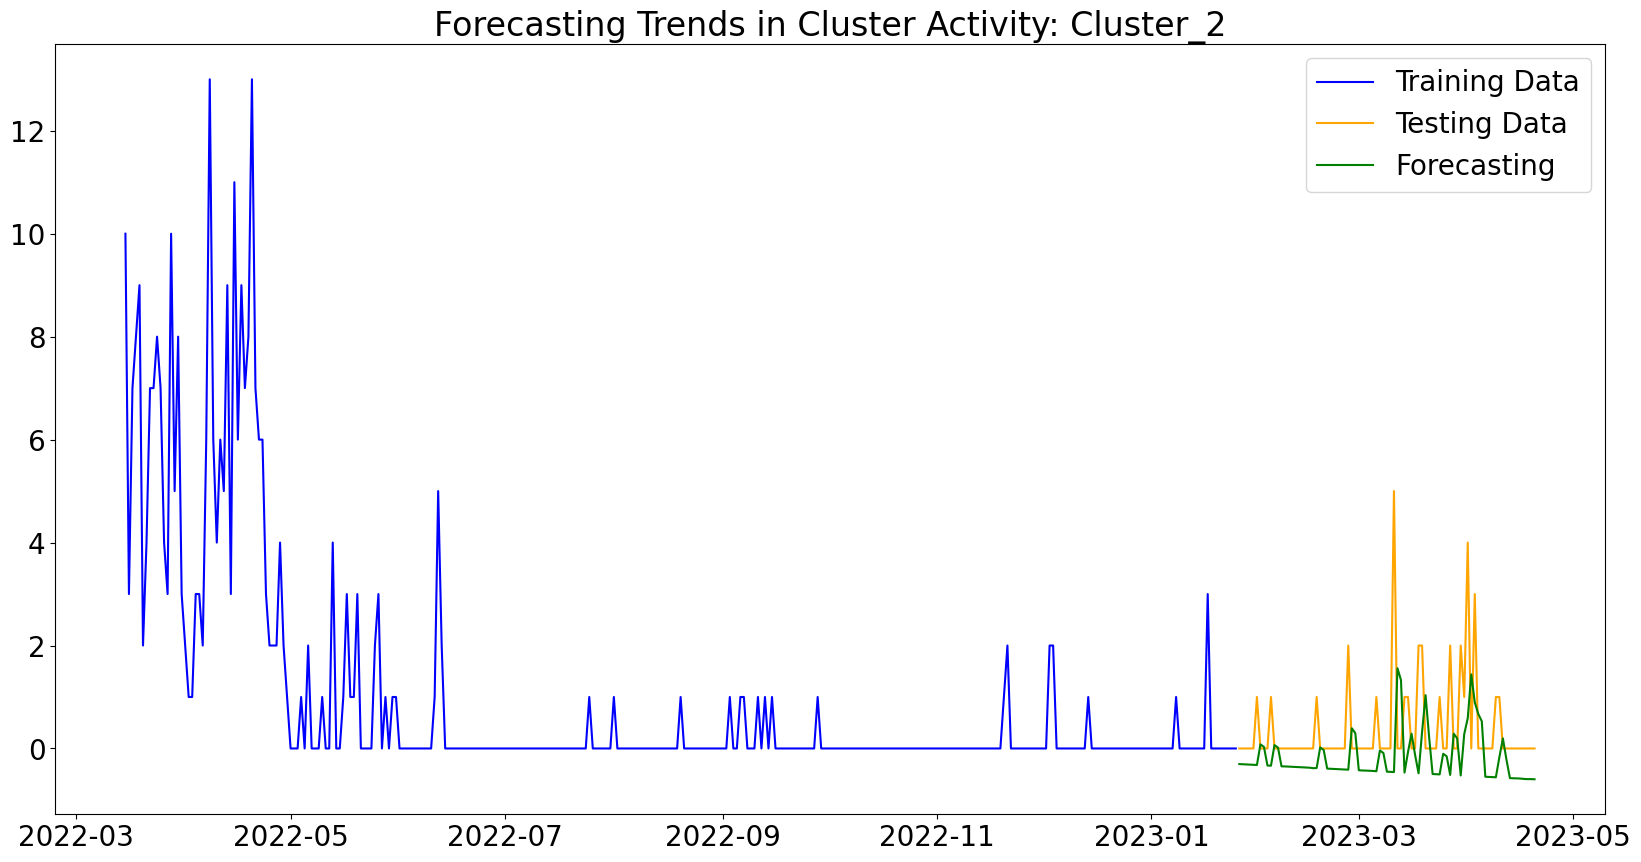

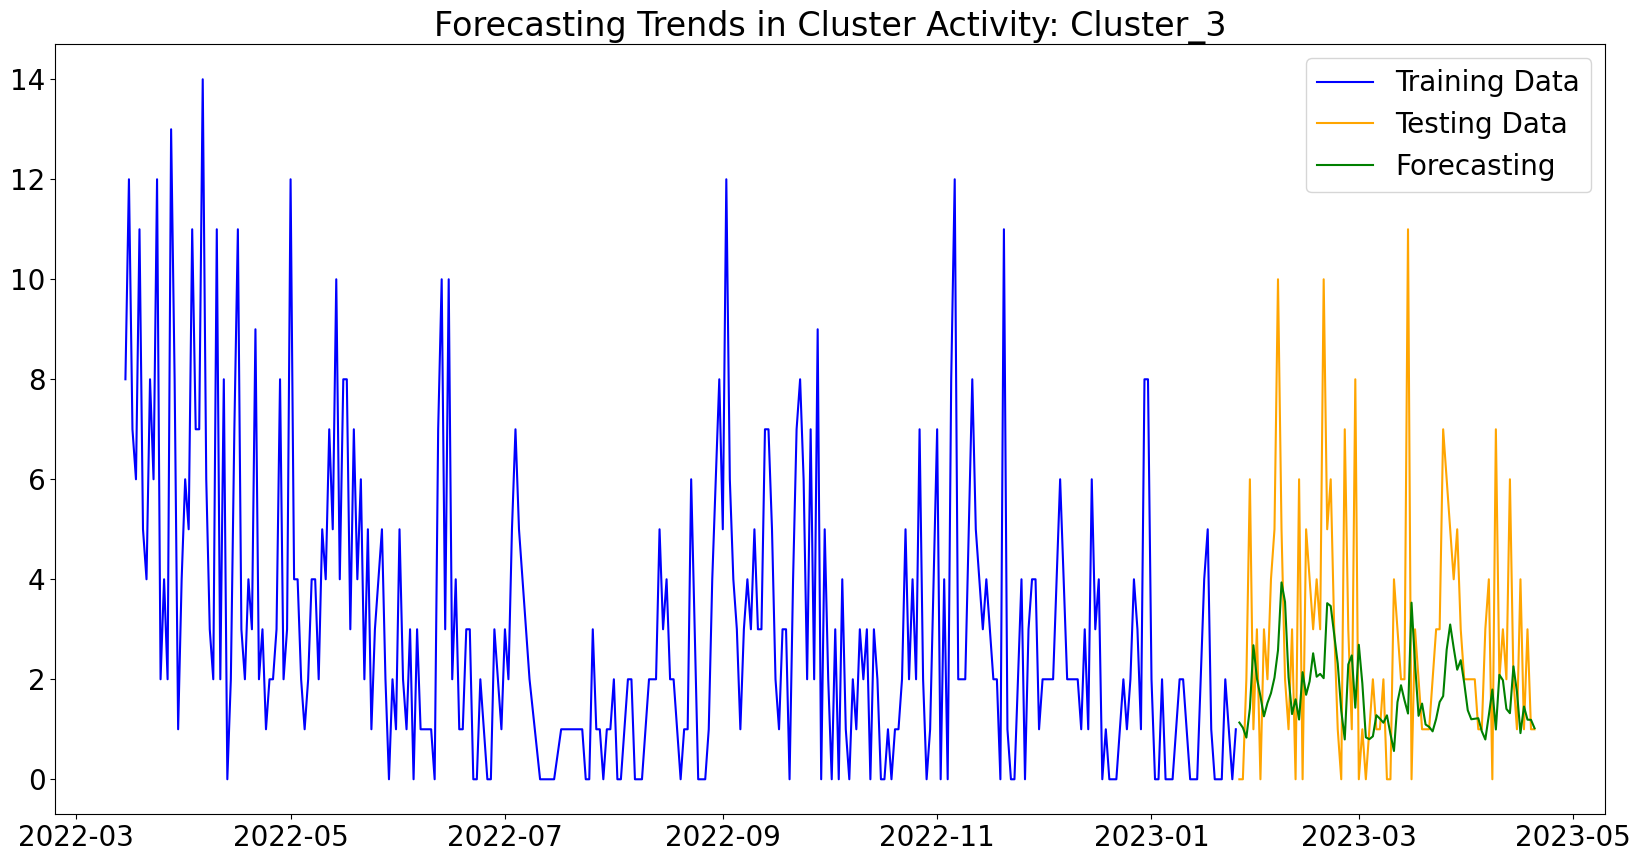

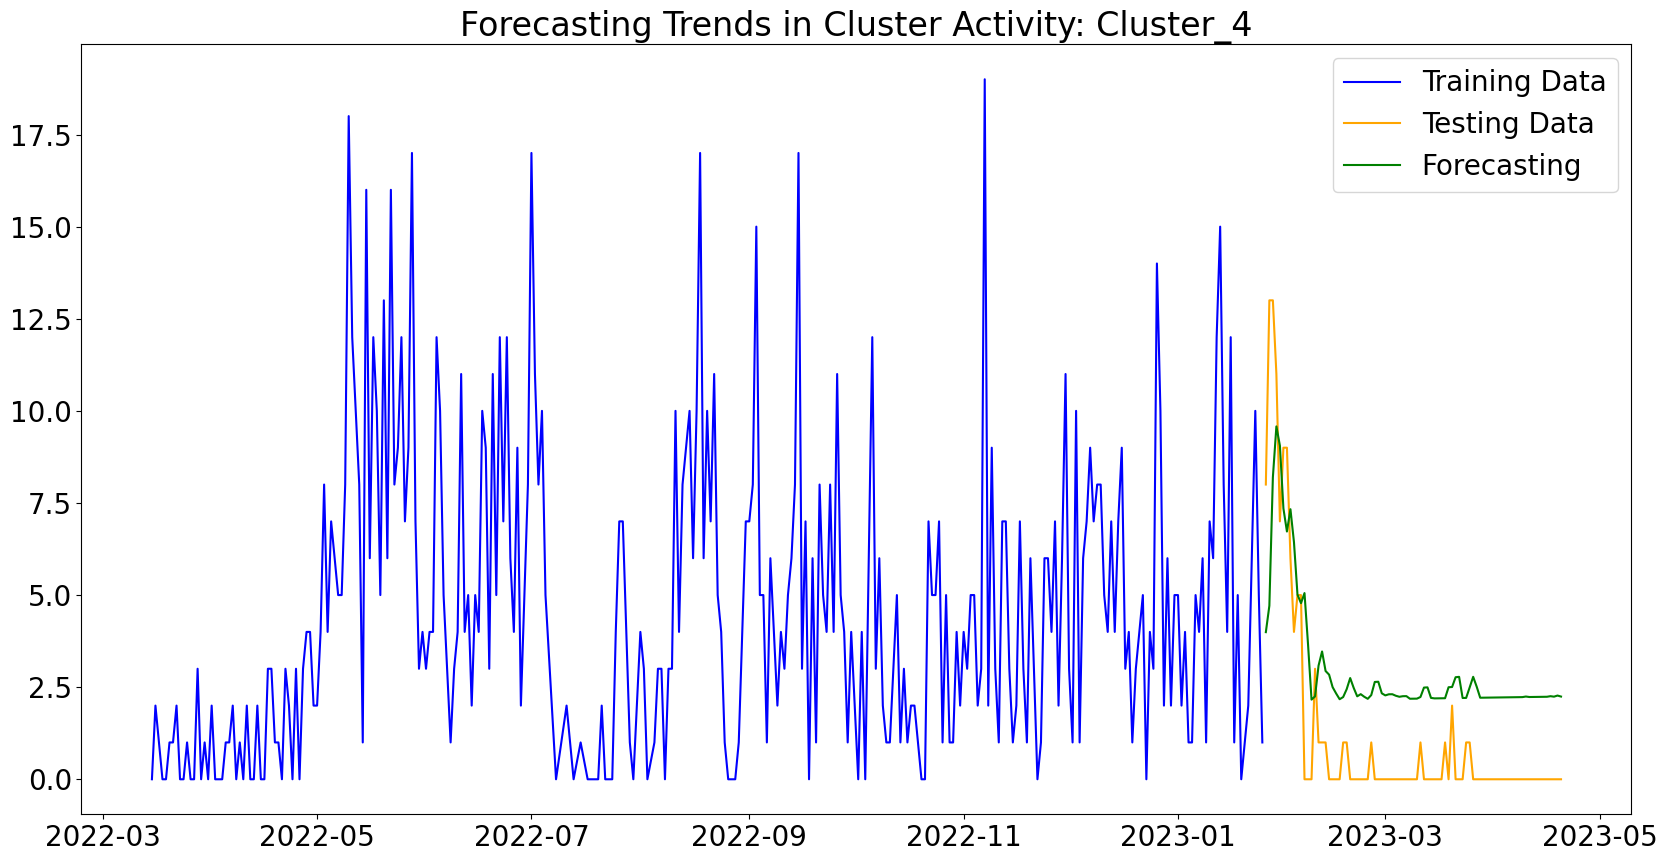

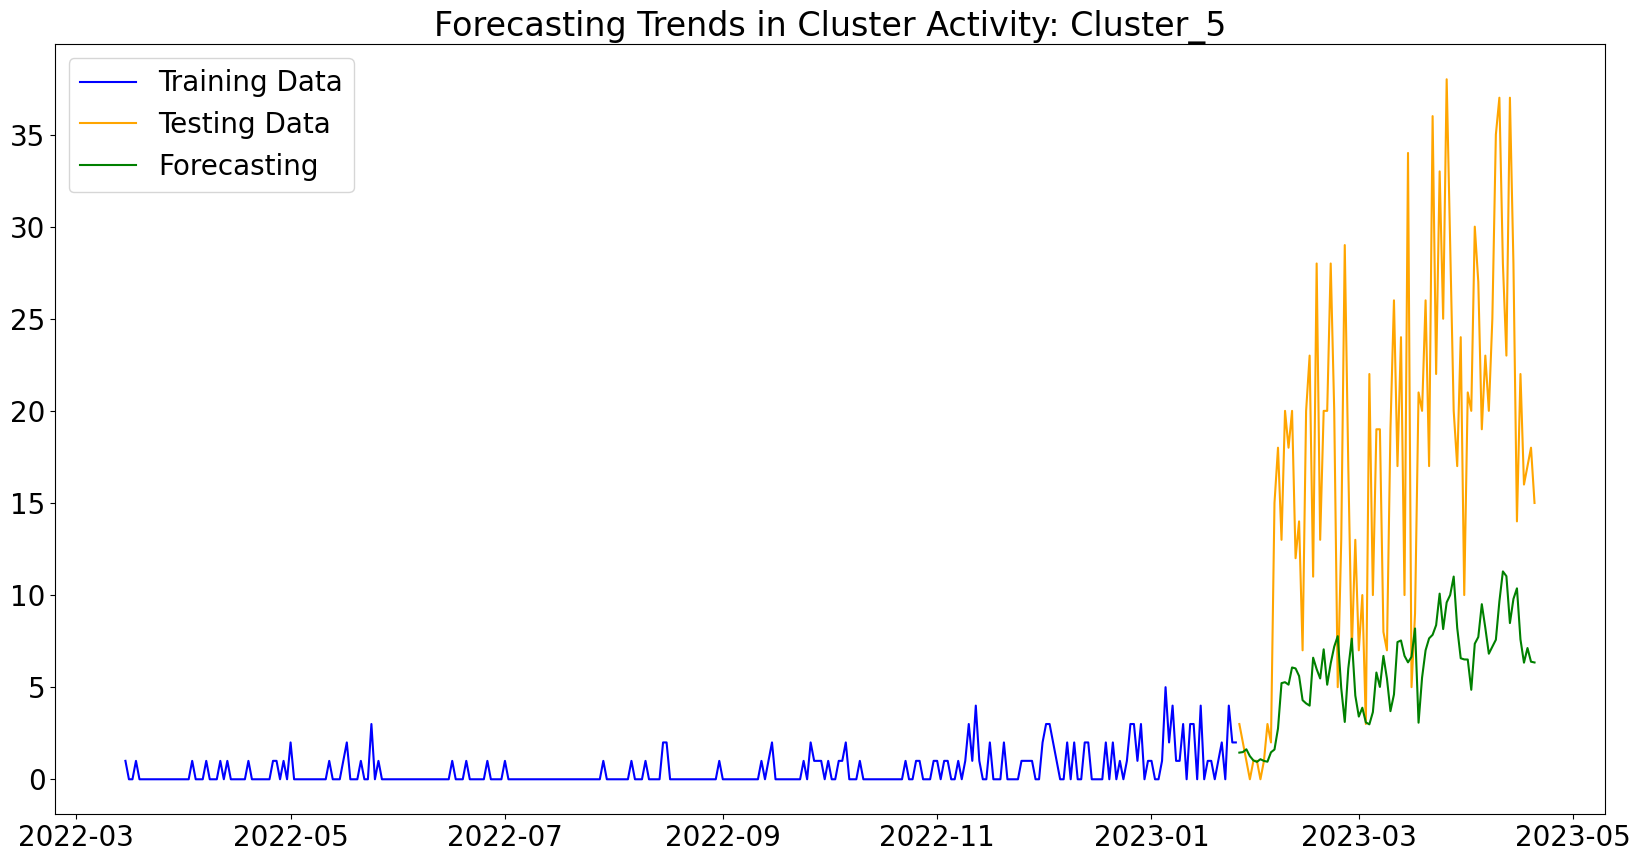

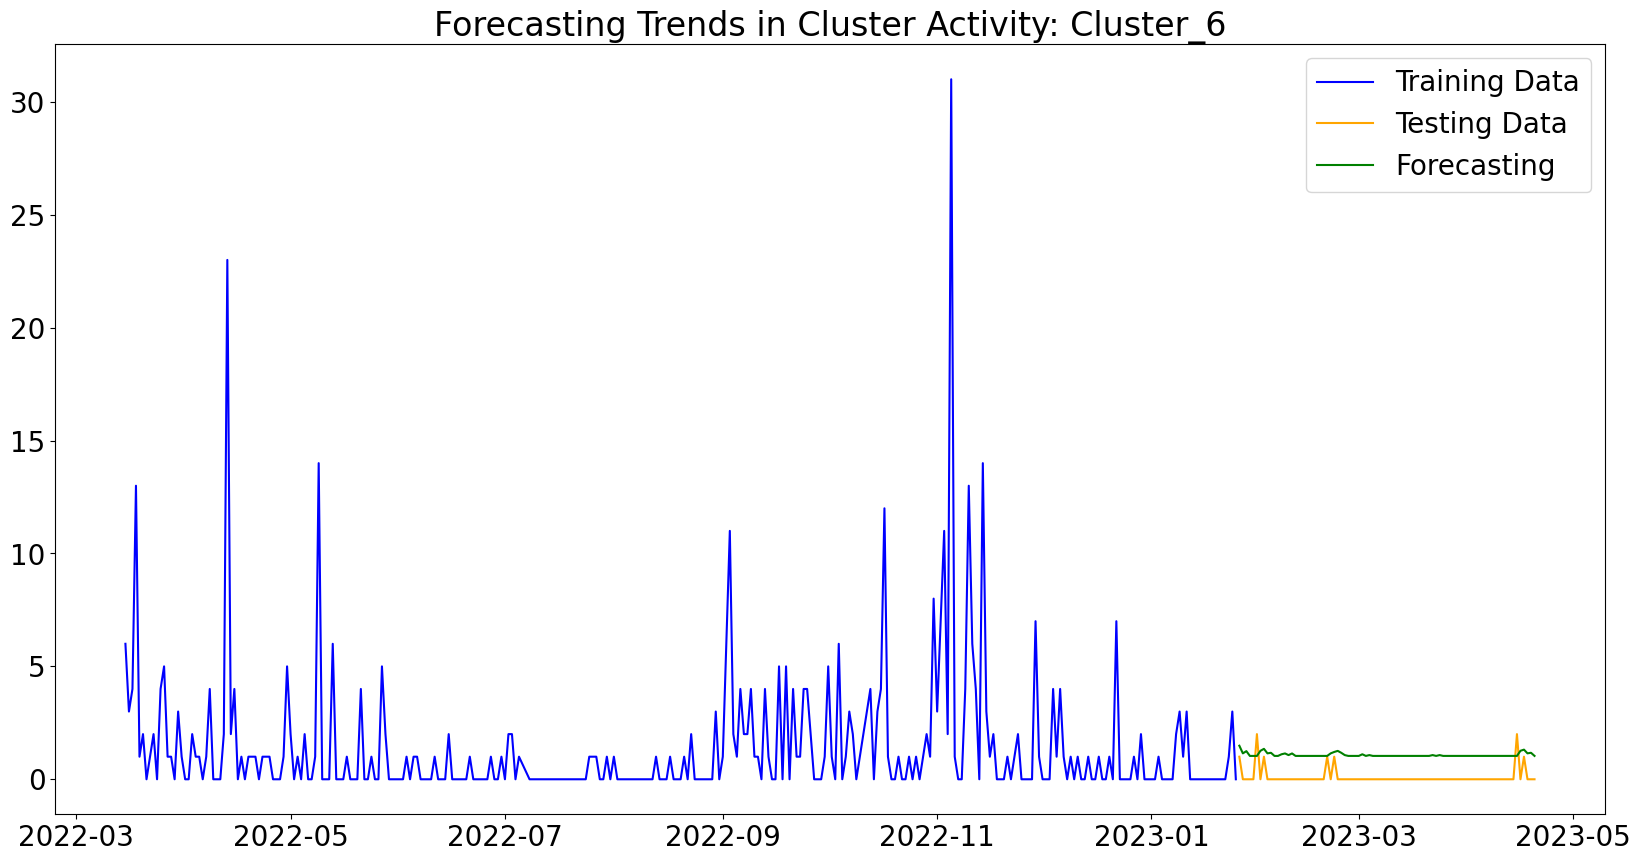

In [95]:
# I am going to forecast, once with regular linear regression.
columns_to_iterate = ['Cluster_0', 'Cluster_1', 'Cluster_2', 'Cluster_3', 'Cluster_4', 'Cluster_5', 'Cluster_6']
for column_name, column_data in activity_counts_df[columns_to_iterate].items():
    
    # Create a column called `lag_1` that lags Clusters by one day.
    activity_counts_df['lag_1'] = activity_counts_df[column_name].shift(1)

    # Create a column called `lag_2` that lags Clusters by two days.
    activity_counts_df['lag_2'] = activity_counts_df[column_name].shift(2)

    # Create a column called `seasonal_12` that lags Clusters by one month(ish).
    activity_counts_df['seasonal_30'] = activity_counts_df[column_name].shift(30)

    # Create a variable called `time` that takes on a value of 0 in Feb 2022,
    # then increases by 1 each day until the end of the dataframe.
    activity_counts_df['time'] = range(0, activity_counts_df.shape[0])
    
    
    X_train, X_test, y_train, y_test = train_test_split(activity_counts_df[['lag_1', 'lag_2', 'seasonal_30', 'time']],
                                                    activity_counts_df[column_name],
                                                    test_size = 0.2, shuffle= False)
    #Accoutrements to process the data
    X_train = sm.add_constant(X_train)
    X_test = sm.add_constant(X_test)
    X_train.dropna(inplace=True)
    y_train = y_train[X_train.index]
    
    #Linear modeling time
    lm = sm.OLS(y_train, X_train)
    lm_results = lm.fit()
    
    print(f"The summary of {column_name} is:")
    print(f"{lm_results.summary()}")
    
    #Generate and store predicted y values for each cluster
    y_pred = lm_results.predict(X_test)
    
    # Set figure size.
    plt.figure(figsize=(20,10))

    # Plot training data.
    plt.plot(y_train.index, y_train.values, color = 'blue', label = 'Training Data')

    # Plot testing data.
    plt.plot(y_test.index, y_test.values, color = 'orange', label = 'Testing Data')

    # Plot predicted test values.
    plt.plot(lm_results.predict(X_test), color = 'green', label = 'Forecasting')

    # Set label.
    plt.title(label = 'Forecasting Trends in Cluster Activity: ' + column_name, fontsize=24)
    plt.legend(['Training Data', 'Testing Data', 'Forecasting'], fontsize=20)
    # Resize tick marks.
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20);

**Doing linear regression on the clusters results in some findings:**
- All clusters except Cluster 2 were not fit particularily well. Cluster 2 was likely fit well because there was a clear spike pattern in the training data that continued to be modeled in the last fifth of the data (most recent testing data). This cluster was associated with the seige of Mariupol, which concluded almost a year ago and has not seen any major consistent activity since that might buck the trend.
- The results were all significant (P-value below 0.02 in all cases). 
- When analyzing the forecast plots with the actual training data, with the exceptions of Clusters 4 and 6, the forecast underpredicted what the actual number of posts were for those days. Clusters 4 and 6 overpredicted the actual number of posts. Cluster 4 probably overpredicted it because Ukrainian activity since the end of the country's counteroffensive has been about shoring up defensive areas, and there have been fewer posts about Ukrainian positions since then. Cluster 6, as previously mentioned, has to do with the usage and publishing of satellite imagery data, and since there is less of a need to use imagery to analyze the battlefield conditions, the number of posts have decreased recently. Both of these might change in a future Ukrainian offensive.
- What we do see, through analyzing the positive lag coefficients and the positive R2 value, that the previous day's activities _do_ help forecast the current days and future days. This makes sense, as activities that are newsworthy are likely to stay newsworthy for at least a few days after. Interestingly, for Cluster 0, troop movements, it predicted decently a month out. This makes sense, as a lot of initial posts and activities about troops and materials moving around do not come to fruition until days or weeks later. For example, Russian troops mobilizing to an area can be reported about once they've been announced as mobilizing, and then again after they have arrived.

## Summary of EDA and Identification of Clusters

- **Cluster 0: Russian Movements and Activities**. This cluster is focused on Russian movements, troops, and vehicles, inside Ukraine, Russia, and Belarus. This cluster is predictive in the long-term, as announcements or observations of movement are reported on early on, and again reported once the movement has taken place, typically at least a week out. This cluster is helpful to look at as a precursor to offenses, as spikes in activities are associated with Russian mobilizations and deployments. <br><br>

- **Cluster 1: Global Russian and Ukrainian Activities**. This cluster has the most amount of posts in it, has a much more global dispersal, and is more generalizable, focused on Russian and Ukrainian-related activities writ-large. This cluster's activity has stayed relatively consistent since November 2022, at a lower level than previously. It will be interesting if other clusters evolve to envelop more of the data as the conflict continues.<br><br>

- **Cluster 2: The Siege of Mariupol**. This cluster is directly related to activities around the siege of the city of Mariupol. It is geographically focused on the city, and the timeline of events back it up. The siege was initiated early on in the conflict, was reported on as the city was bombed and assaulted by Russian soldiers, and then eventually activity lulled when the Ukrainian soldiers surrendered. Recently activity spiked due to Russian President Vladimir Putin visiting the city in March 2023. There is predicted to be little activity in this cluster, though if activity in this cluster picks up it might be indicative of a Ukrainian push to retake the city.<br><br>

- **Cluster 3: The Destruction Cluster**. This cluster is focused on destruction wrought by both Russia and Ukraine, as the geographic locations, presumably locations of shelling and other attacks, of these activities are contained largely within Ukraine and Russia. This cluster seems to be related to offenses taken by either side, as well as lulls in fighting as artillery and materiel supplies dwindle. There has recently been an increase in activity in this cluster, as Russia had initiated an offensive in the Donbas region of Ukraine.<br><br>

- **Cluster 4: Ukrainian Positions and Activities**. This cluster is focused on what Ukraine is doing in its battle plans. Activities related to troop movements, positioning, and UAV flights. Geographically the locations of the activities are focused in Eastern Ukraine, as there is a focus on defending the Donbas region. Previous spikes in activity have occurred when Ukraine was moving troops to retake parts of the country. Notably, this cluster has seen a significant decrease in activity recently, but very likely any increase in activity in this cluster means a possible Ukrainian counteroffensive.<br><br>

- **Cluster 5: Battle for Bakhmut**. This cluster is focused on the Donbas, specifically the Donetsk Oblast in Ukraine. It is primarily concerned with activities around the besieged city, which has seen intense fighting since the late Fall, as Russia has focused its efforts on taking this city. It has very recently seen a massive spike in activity, as Russia's offsensive and Ukraine's fierce defense has resulted in the most active part of the conflict right now. Continued increase in this cluster is going to be indicative of intense fighting for the city. If this cluster decreases, it likely means the city has been taken over or is on the verge of being taken over by either side.<br><br>

- **Cluster 6: Satellite Imagery**. This cluster is focused all over Ukraine and in neighboring countries, and is associated with images and reporting that uses satellite imagery. There have been noteworthy spikes in this cluster since the conflict began, and seems to be indicative of potential uncovering of human rights abuses and atrocities. For example, there was a spike of activity in April 2022, when satellite imagery was used to uncover human rights abuses in the city of Bucha outside Kyiv. This was again repeated in November of 2022, when Ukraine concluded its counteroffensive and took back territory in Kherson and Kharkiv, and again satellite imagery helped uncover evidence of atrocities in the towns formerly controlled by the Russian forces. There has been a lull in this cluster recently, but any increase in activity in this cluster might be indicative of using satellite imagery to document cases of activities that journalists or people keyed in to social media cannot get to.
